In [34]:
#!pip install pandas==1.3.1
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Input 
from tensorflow.keras.layers import Conv1D, Flatten, MaxPooling1D, UpSampling1D, Reshape, Concatenate, Multiply, Lambda
from tensorflow.keras.backend import int_shape
from keras import backend as bken
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from keras.callbacks import LearningRateScheduler
import keras
from keras import layers
from tensorflow.keras.backend import int_shape
import os
from scipy.special import comb
import lr_scheduler

In [2]:
#!wget -o pd_data_dp_subset.p https://ucf318623584668d8740ede597a1.dl.dropboxusercontent.com/cd/0/get/BaPWpCQuhyIKlS1VCIa39IJm_f8YpUzm7Ix5c4H57oShk37iLp4BMZ07rThcDnUIyzk_r857u-Vj76bdZYKWkpEOwMHpW5W1-snEr4WDjbUC_XE0mEJvOnlAXTP0YA1vMPiBhmlIEkSgCQkpaa0-rHWl/file# --show-progress
#!mv file pd_data_dp_subset.p

In [3]:
#!mkdir checkpoints & mkdir checkpoints/model_01
#!unzip 0100.ckpt.zip -d checkpoints/model_01/

### Read dataset

In [4]:
df = pd.read_pickle('pd_data_dp_subset.p')

# ---- recast event_id to int
df["event_id"] = df["event_id"].apply(lambda x:int(x))

### Header
    1. P_wave_processed: pre-processed p-wave recordings, each of them has dim = (600, 3)
    2. P_wave_amplitudes: max(amplitude) of raw p-wave recordings, each of them has dim = (3,)
    3. azimuth: the azimuth of earthquake with respect to station
    4. station_name: name of the station
    5. station_network: netowrk code of the station
    6. event_id: event id
    7. depth: event depth
    8. station_lat: station coordinate lat.
    9. station_long: station coordinate long.
    10. event_lat: event coordinate lat
    11. event_long: event coordinate long
    12. magnitude: event magnitude
    13. P: phase arrival time at station
    14. delta: event station distance in degree (1 degree ~= 111 km)

In [5]:
df.head(3)

,station_name,station_network,station_lat,station_long,event_id,event_time,event_lat,event_long,depth,P_wave_processed,azimuth,delta,phase,P,magnitude
0,AAK,II,42.637500,74.494200,1725583,9.470968e+08,-9.131,109.579,35.0,"[[4.5132976810436585e-17, 0.0, -5.126423482750...",330.887,60.666,P,9.470974e+08,5.6
1,AAK,KN,42.633301,74.494400,1725583,9.470968e+08,-9.131,109.579,35.0,"[[-0.004384802184109918, 0.002776395732707534,...",330.887,60.666,P,9.470974e+08,5.6
2,AML,KN,42.131100,73.694099,1725583,9.470968e+08,-9.131,109.579,35.0,"[[-0.003072967942240945, 0.002691759337183582,...",329.993,60.675,P,9.470974e+08,5.6


### Some facts of the dataset

In [6]:
total_entries = df.shape[0]
print(f"total {total_entries} entries")
event_number = pd.unique(df.event_id).shape[0]
print(f"total {event_number} events")
station_number = pd.unique(df.station_name).shape[0]
print(f"total ~{station_number} stations")
min_distance = df.delta.min()
max_distance = df.delta.max()
median_distance = df.delta.median()
print(f"min station-event distance {min_distance:.3f} degree")
print(f"max station-event distance {max_distance:.3f} degree")
print(f"median station-event distance {median_distance:.3f} degree")

total 145677 entries
total 1295 events
total ~1574 stations
min station-event distance 0.199 degree
max station-event distance 90.866 degree
median station-event distance 68.233 degree


### Split train and test set
To prevent data leaking from one event to another one, we will split dataset by event

In [7]:
# Group by event and aggregate relevant columns
df_evt_grouped = df.groupby('event_id').agg(
    {'station_name': lambda x:list(x),
     'station_network': lambda x:list(x),
     'station_lat': lambda x:list(x),
     'station_long': lambda x:list(x),
     'P_wave_processed': lambda x:np.asarray(list(x))
    }).reset_index()
df_evt_grouped["num_waves"] = df_evt_grouped["P_wave_processed"]\
                              .apply(lambda x: x.shape[0])

# ---- drop events that only has one recording
df_evt_grouped = df_evt_grouped[df_evt_grouped.num_waves>=2]

In [8]:
# Split train and test sets
train_set, test_set, _, _ = train_test_split(df_evt_grouped, 
                                             df_evt_grouped, 
                                             test_size=0.2, 
                                             random_state=42)

In [9]:
num_train_events = train_set.shape[0]
num_train_waves = train_set.num_waves.sum()
num_test_events = test_set.shape[0]
num_test_waves = test_set.num_waves.sum()
print(f"Number of train event: {num_train_events}")
print(f"Number of train waves: {num_train_waves}")
print(f"Number of test event: {num_test_events}")
print(f"Number of test waves: {num_test_waves}")

Number of train event: 1034
Number of train waves: 117692
Number of test event: 259
Number of test waves: 27983


### Data for  the Resnet style Autoencoder

In [10]:
df_train_set_flat = train_set.explode(['P_wave_processed'])

In [11]:
waves_train = np.asarray((df_train_set_flat.P_wave_processed.to_list()))

In [12]:
#df_evt_grouped[["event_id","P_wave_processed"]].explode(['P_wave_processed'])

### Model 1. 1D-Resnet style autoencoder

In [13]:
def identity_block(x, num_filters=64, kernel_size=5):
    
    # copy tensor to variable called x_skip
    x_skip = x
    
    # Layer 1
    x = tf.keras.layers.Conv1D(num_filters, kernel_size, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Layer 2
    x = tf.keras.layers.Conv1D(num_filters, kernel_size, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [14]:
def reverse_identity_block(x, num_filters=64, kernel_size=5):
    
    # copy tensor to variable called x_skip
    x_skip = x
    
    # Layer 1
    x = tf.keras.layers.Conv1DTranspose(num_filters, kernel_size, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Layer 2
    x = tf.keras.layers.Conv1DTranspose(num_filters, kernel_size, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [15]:
def ResAutoencoder(x_input_shape=(600,3),
                   encoding_dim=100,
                   num_res_blocks=9, 
                   max_pool_itval=3,
                   pooling_dim = 2):
    
    # ============================================ #
    # ============= Define the ENCODER =========== #
    # ============================================ #
    inputs = keras.Input(shape=x_input_shape, name='encoder_input')
    x = inputs

    # ---- inital cov block
    x = tf.keras.layers.Conv1D(32, 7, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # ---- Residual blocks
    for r in range(1, num_res_blocks + 1):
        
        x = identity_block(x, num_filters=32, kernel_size=5)
        
        # --- apply maxpooling after every n res blocks
        if r % max_pool_itval == 0:
            x = tf.keras.layers.MaxPooling1D(pooling_dim, padding='same')(x)
    
    # ============================================ #
    # ============= Define the LATENT  =========== #
    # ============================================ #
    shape_before_flatten = int_shape(x)[1:]
    x = Flatten()(x)  
    latent = Dense(encoding_dim, name='latent_layer')(x)
    encoder = Model(inputs=inputs, outputs=latent, name='encoder')
    
    # ============================================ #
    # ============= Define the DECODER =========== #
    # ============================================ #
    
    # ---- reshape back to the dim before flatten
    latent_inputs = Input(shape=(encoding_dim), name='decoder_input')
    x = latent_inputs
    x = Dense(units=np.prod(shape_before_flatten))(x)
    x = Reshape(target_shape=shape_before_flatten)(x)
    
    # ---- Residual blocks
    for r in range(0, num_res_blocks-1):
        
        # --- apply maxpooling after every n res blocks
        
        if r % max_pool_itval == 0:
            x = tf.keras.layers.UpSampling1D(pooling_dim)(x)
        
        x = reverse_identity_block(x, num_filters=32, kernel_size=5)
    
    # ---- Final cov block
    x = tf.keras.layers.Conv1DTranspose(32, 7, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # ---- Final layer
    output = Dense(units=x_input_shape[1])(x)

    # ---- Build and compile decoder    
    decoder = Model(inputs=latent_inputs, outputs=output, name='decoder')
    
    # ---- combine encoder and decoder
    autoencoder = Model(inputs=inputs, 
                        outputs=decoder(encoder(inputs)), 
                        name='autoencoder')
    return autoencoder, encoder, decoder

In [16]:
res_autoencoder, encoder, decoder = ResAutoencoder(x_input_shape=(600,3),
                     encoding_dim=100,
                     num_res_blocks=9, 
                     max_pool_itval=3,
                     pooling_dim = 2)
res_autoencoder.summary()
#encoder.summary()
#decoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 600, 3)]          0         
_________________________________________________________________
encoder (Functional)         (None, 100)               335972    
_________________________________________________________________
decoder (Functional)         (None, 600, 3)            334307    
Total params: 670,279
Trainable params: 667,975
Non-trainable params: 2,304
_________________________________________________________________


In [17]:
def return_tbcallbacks(model_name=None):
    # ------ define tensorboard callback
    if model_name is None:
        model_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    else:
        model_name = model_name
    
    logdir = os.path.join("logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,
                                                          histogram_freq=1,
                                                          write_grads=True)
    # ------ check point call backs
    checkpointdir = os.path.join("checkpoints", model_name)
    checkpointpath = os.path.join(checkpointdir, "{epoch:04d}.ckpt")
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpointpath,
                                                     save_weights_only=False,
                                                     verbose=5)
    return tensorboard_callback, cp_callback

In [18]:
def lr_scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 30
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]
optimizer = optimizers.Adam(learning_rate=0.001)

In [19]:
res_autoencoder.compile(loss='mse', optimizer=optimizer)

tensorboard_callback, cp_callback = return_tbcallbacks(model_name='model_01')
history_model_one = res_autoencoder.fit(waves_train,
                                         waves_train,
                                         epochs=50, 
                                         batch_size=32, 
                                         verbose=1, 
                                         validation_split=0.2,
                                         callbacks=[tensorboard_callback,cp_callback])

/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/50
2943/2943 [==============================] - 91s 27ms/step - loss: 0.0442 - val_loss: 0.0268

Epoch 00001: saving model to checkpoints/model_01/0001.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
2943/2943 [==============================] - 78s 27ms/step - loss: 0.0226 - val_loss: 0.0218

Epoch 00002: saving model to checkpoints/model_01/0002.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0211 - val_loss: 0.0206

Epoch 00003: saving model to checkpoints/model_01/0003.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/50
2943/2943 [==============================] - 78s 27ms/step - loss: 0.0203 - val_loss: 0.0201

Epoch 00004: saving model to checkpoints/model_01/0004.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0199 - val_loss: 0.0196

Epoch 00005: saving model to checkpoints/model_01/0005.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0196 - val_loss: 0.0195

Epoch 00006: saving model to checkpoints/model_01/0006.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0195 - val_loss: 0.0194

Epoch 00007: saving model to checkpoints/model_01/0007.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0194 - val_loss: 0.0193

Epoch 00008: saving model to checkpoints/model_01/0008.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/50
2943/2943 [==============================] - 78s 27ms/step - loss: 0.0192 - val_loss: 0.0194

Epoch 00009: saving model to checkpoints/model_01/0009.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0191 - val_loss: 0.0191

Epoch 00010: saving model to checkpoints/model_01/0010.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0191 - val_loss: 0.0192

Epoch 00011: saving model to checkpoints/model_01/0011.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0190 - val_loss: 0.0190

Epoch 00012: saving model to checkpoints/model_01/0012.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0189 - val_loss: 0.0191

Epoch 00013: saving model to checkpoints/model_01/0013.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0188 - val_loss: 0.0190

Epoch 00014: saving model to checkpoints/model_01/0014.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0188 - val_loss: 0.0190

Epoch 00015: saving model to checkpoints/model_01/0015.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/50
2943/2943 [==============================] - 78s 27ms/step - loss: 0.0187 - val_loss: 0.0192

Epoch 00016: saving model to checkpoints/model_01/0016.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/50
2943/2943 [==============================] - 78s 27ms/step - loss: 0.0187 - val_loss: 0.0189

Epoch 00017: saving model to checkpoints/model_01/0017.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/50
2943/2943 [==============================] - 78s 27ms/step - loss: 0.0186 - val_loss: 0.0190

Epoch 00018: saving model to checkpoints/model_01/0018.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0186 - val_loss: 0.0188

Epoch 00019: saving model to checkpoints/model_01/0019.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/50
2943/2943 [==============================] - 78s 27ms/step - loss: 0.0185 - val_loss: 0.0189

Epoch 00020: saving model to checkpoints/model_01/0020.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/50
2943/2943 [==============================] - 78s 27ms/step - loss: 0.0185 - val_loss: 0.0188

Epoch 00021: saving model to checkpoints/model_01/0021.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/50
2943/2943 [==============================] - 78s 27ms/step - loss: 0.0185 - val_loss: 0.0189

Epoch 00022: saving model to checkpoints/model_01/0022.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0184 - val_loss: 0.0188

Epoch 00023: saving model to checkpoints/model_01/0023.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0184 - val_loss: 0.0189

Epoch 00024: saving model to checkpoints/model_01/0024.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0184 - val_loss: 0.0187

Epoch 00025: saving model to checkpoints/model_01/0025.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 26/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0183 - val_loss: 0.0187

Epoch 00026: saving model to checkpoints/model_01/0026.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0183 - val_loss: 0.0188

Epoch 00027: saving model to checkpoints/model_01/0027.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0183 - val_loss: 0.0187

Epoch 00028: saving model to checkpoints/model_01/0028.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 29/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0183 - val_loss: 0.0187

Epoch 00029: saving model to checkpoints/model_01/0029.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 30/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0182 - val_loss: 0.0188

Epoch 00030: saving model to checkpoints/model_01/0030.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0182 - val_loss: 0.0186

Epoch 00031: saving model to checkpoints/model_01/0031.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0182 - val_loss: 0.0187

Epoch 00032: saving model to checkpoints/model_01/0032.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 33/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0182 - val_loss: 0.0186

Epoch 00033: saving model to checkpoints/model_01/0033.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/50
2943/2943 [==============================] - 78s 27ms/step - loss: 0.0182 - val_loss: 0.0186

Epoch 00034: saving model to checkpoints/model_01/0034.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 35/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0181 - val_loss: 0.0187

Epoch 00035: saving model to checkpoints/model_01/0035.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 36/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0181 - val_loss: 0.0187

Epoch 00036: saving model to checkpoints/model_01/0036.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 37/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0181 - val_loss: 0.0186

Epoch 00037: saving model to checkpoints/model_01/0037.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 38/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0181 - val_loss: 0.0187

Epoch 00038: saving model to checkpoints/model_01/0038.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 39/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0181 - val_loss: 0.0186

Epoch 00039: saving model to checkpoints/model_01/0039.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 40/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0180 - val_loss: 0.0189

Epoch 00040: saving model to checkpoints/model_01/0040.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 41/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0180 - val_loss: 0.0187

Epoch 00041: saving model to checkpoints/model_01/0041.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 42/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0180 - val_loss: 0.0187

Epoch 00042: saving model to checkpoints/model_01/0042.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 43/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0180 - val_loss: 0.0186

Epoch 00043: saving model to checkpoints/model_01/0043.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 44/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0180 - val_loss: 0.0185

Epoch 00044: saving model to checkpoints/model_01/0044.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 45/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0180 - val_loss: 0.0185

Epoch 00045: saving model to checkpoints/model_01/0045.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 46/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0180 - val_loss: 0.0187

Epoch 00046: saving model to checkpoints/model_01/0046.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 47/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0180 - val_loss: 0.0186

Epoch 00047: saving model to checkpoints/model_01/0047.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 48/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0179 - val_loss: 0.0186

Epoch 00048: saving model to checkpoints/model_01/0048.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 49/50
2943/2943 [==============================] - 78s 27ms/step - loss: 0.0179 - val_loss: 0.0186

Epoch 00049: saving model to checkpoints/model_01/0049.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 50/50
2943/2943 [==============================] - 79s 27ms/step - loss: 0.0179 - val_loss: 0.0187

Epoch 00050: saving model to checkpoints/model_01/0050.ckpt


/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


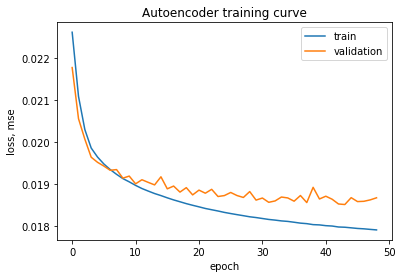

In [20]:
import matplotlib.pyplot as plt
start = 1
plt.plot(history_model_one.history['loss'][start:], label='train')
plt.plot(history_model_one.history['val_loss'][start:], label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss, mse')
plt.title('Autoencoder training curve')
plt.show()

### Load in pre-trained encoder model 

In [21]:
model_name = "model_01"
epoch = 20
path_to_model = f'./checkpoints/{model_name}/{epoch:04d}.ckpt'
autoencoder = tf.keras.models.load_model(path_to_model)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 600, 3)]          0         
_________________________________________________________________
encoder (Functional)         (None, 100)               335972    
_________________________________________________________________
decoder (Functional)         (None, 600, 3)            334307    
Total params: 670,279
Trainable params: 667,975
Non-trainable params: 2,304
_________________________________________________________________


### Get encoder 

In [22]:
encoder_input = autoencoder.get_layer('encoder_input')
encoder = autoencoder.get_layer('encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 600, 3)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 600, 32)      704         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 600, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 600, 32)      0           batch_normalization[0][0]        
____________________________________________________________________________________________

### Data pre-processing for Barlow-twins input
1. Strat from the grouped waveforms
2. Pair up each of the waveforms

In [23]:
train_set_bt = train_set.copy()

In [24]:
import itertools
def pair_up_waveform(waves):
    
    # ---- count number of entries
    num_entries = waves.shape[0]
    
    # ---- create pair of two
    pair_index = list(set(itertools.combinations(np.arange(num_entries),2)))
    pair_index = np.asarray(pair_index).T
    
    return pair_index

In [25]:
# ----- create indexes of pair of two
train_set_bt["pair_index"] = train_set["P_wave_processed"].apply(lambda x: pair_up_waveform(x))
train_set_bt["num_pairs"] = train_set["num_waves"].apply(lambda x: int(comb(x,2)))

num_of_pairs = train_set_bt.num_pairs.sum()
print(f"total number of pairs: {num_of_pairs}")
num_of_events = len(train_set_bt)
print(f"total number of events: {num_of_events}")

total number of pairs: 10061755
total number of events: 1034


In [27]:
# ----- now we can populate waveform pairs to numpy arrays
# set a max number of pair per event, if memory is an issue
max_num_pair = 200
total_pairs = num_of_events * max_num_pair

waves_one = np.zeros((total_pairs, 600, 3))
waves_two = np.zeros((total_pairs, 600, 3))

counter = 0
for i in range(len(train_set_bt)):
    
    indexes_for_waves_one = train_set_bt.iloc[i].pair_index[0]
    indexes_for_waves_two = train_set_bt.iloc[i].pair_index[1]
    
    if len(indexes_for_waves_one) > max_num_pair:
        indexes_for_waves_one = indexes_for_waves_one[0:max_num_pair]
        indexes_for_waves_two = indexes_for_waves_one[0:max_num_pair]
    
    num_of_combs = len(indexes_for_waves_one) + counter
    
    # ---- get waves and put into the pre-instatiiated np arrays
    waves_one[counter:num_of_combs,:,:] = train_set_bt.iloc[i]["P_wave_processed"][indexes_for_waves_one,:,:]
    waves_two[counter:num_of_combs,:,:] = train_set_bt.iloc[i]["P_wave_processed"][indexes_for_waves_two,:,:]
    
    counter = num_of_combs
    
waves_one = waves_one[:counter,:,:]
waves_two = waves_one[:counter,:,:]

### Barlow-twins part starts here

Inputs:
1. encoder : pre-trained encoder model + a projector
2. waves_one : wave copy one
3. waves_two : wave copy two

In [29]:
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diagonals = tf.reshape(flattened, (n-1, n+1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])


def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    return z_norm


def compute_loss(z_a, z_b, lambd):
    # Get batch size and representation dimension.
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss

In [35]:
class BarlowTwins(tf.keras.Model):
    def __init__(self, encoder, lambd=5e-3):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.lambd = lambd
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z_a, z_b = self.encoder(ds_one, training=True), self.encoder(ds_two, training=True)
            loss = compute_loss(z_a, z_b, self.lambd) 

        # Compute gradients and update the parameters.
        gradients = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [36]:
BATCH_SIZE = 32
EPOCHS = 100
STEPS_PER_EPOCH = waves_one.shape[0] // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = lr_scheduler.WarmUpCosine(
    learning_rate_base=1e-3,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

In [37]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)

In [38]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(waves_one)
ssl_ds_two = tf.data.Dataset.from_tensor_slices(waves_two)

SEED = 0

ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

In [39]:
barlow_twins = BarlowTwins(encoder)
barlow_twins.compile(optimizer=optimizer)
#tensorboard_callback, cp_callback = return_tbcallbacks(model_name='barlow_twins')
#callbacks=[cp_callback] tensorboard_callback
history = barlow_twins.fit(ssl_ds, epochs=EPOCHS)

Epoch 1/100
6399/6399 [==============================] - 133s 20ms/step - loss: 1.8748
Epoch 2/100
6399/6399 [==============================] - 127s 20ms/step - loss: 1.7694
Epoch 3/100
6399/6399 [==============================] - 127s 20ms/step - loss: 1.7118
Epoch 4/100
6399/6399 [==============================] - 127s 20ms/step - loss: 1.6864
Epoch 5/100
6399/6399 [==============================] - 127s 20ms/step - loss: 1.6806
Epoch 6/100
6399/6399 [==============================] - 127s 20ms/step - loss: 1.6741
Epoch 7/100
6399/6399 [==============================] - 127s 20ms/step - loss: 1.6700
Epoch 8/100
6399/6399 [==============================] - 127s 20ms/step - loss: 1.6677
Epoch 9/100
6399/6399 [==============================] - 127s 20ms/step - loss: 1.6619
Epoch 10/100
6399/6399 [==============================] - 127s 20ms/step - loss: 1.6602
Epoch 11/100
6399/6399 [==============================] - 127s 20ms/step - loss: 1.6594
Epoch 12/100
6399/6399 [=================

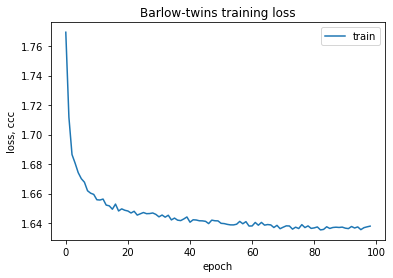

In [75]:
import matplotlib.pyplot as plt
start = 1
plt.plot(history.history['loss'][start:], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss, ccc')
plt.title('Barlow-twins training loss')
plt.show()

In [41]:
barlow_twins.encoder.save('./bt_model/bt_model.h5',save_format='h5')

/home/lchuang/anaconda3/envs/Nukes_LC/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Make predictions for test set

In [57]:
test_set_bt = test_set.copy()

In [63]:
test_set_flat = test_set_bt.set_index('event_id').explode(['station_name',
                                           'station_network',
                                           'station_lat',
                                           'station_long',
                                           'P_wave_processed']).reset_index()

In [67]:
wave_test = np.asarray(test_set_flat.P_wave_processed.to_list())

In [68]:
pred_embedn = barlow_twins.encoder.predict(wave_test)

In [69]:
pred_embedn.shape

(27983, 100)

In [70]:
test_set_flat["pred_embeddings"] = list(pred_embedn)
test_set_flat.head(2)

,event_id,station_name,station_network,station_lat,station_long,P_wave_processed,num_waves,pred_embeddings
0,7223887,AAK,KN,42.633301,74.4944,"[[-0.0054397800811531, 0.006146642442558737, 0...",25,"[2.0686686, -1.1539124, -2.2467422, 5.966675, ..."
1,7223887,AML,KN,42.1311,73.694099,"[[-0.0017225705661397274, 0.001742278627199010...",25,"[2.8171532, -2.6339478, -1.8851807, 2.0183, 1...."


In [71]:
test_set_flat.to_pickle('pred_embeddings_test.pickle')